In [1]:
import my_mps
import d_dmrg
from bosehubbardfile import BoseHubbardModel
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
def my_expectation_value(psi, model):
    for i in range(model.L):
        ket = psi[i]
        bra = np.conj(psi[i])
        contraction = np.tensordot(ket, model.fixed_H_mpo[i], (1,2)) #vL [i] vR , hL hR [hup] hdown
        nextcontraction = np.tensordot(contraction, bra, axes=([4], [1])) #vL vR hL hR [hdown] , vL [i] vR
        #firstcontraction.append(nextcontraction)
        if i == 0: 
            energy = nextcontraction
        else: 
            #print("Energy", energy.shape)
            #print("Contraction", nextcontraction.shape)
            energy = np.tensordot(energy, nextcontraction, axes=([1,3,5],[0,2,4])) #vL [vR] hL [hR] vL [vR],  [vL] vR [hL] hR [vL] vR
            energy = np.transpose(energy, (0,3,2,4,1,5))
    return np.squeeze(energy)

In [3]:
import copy
def dmrg_gs(L, t, U, mu, nc, max_N_sweeps=10, chi_max=50, eps=1.e-10):
    model = BoseHubbardModel(L, t, U, mu, nc)
    psi = my_mps.init_spinup_MPS(L, nc)
    psi_initial = copy.deepcopy(psi.Bs)
    eng = d_dmrg.DMRGEngine(psi, model, chi_max=chi_max, eps=eps)
    Eprev = np.inf
    energyss = []
    for i in range(max_N_sweeps):
        print("sweep", i)
        eng.sweep()
        E = my_expectation_value(psi.Bs, model)
        #if abs((E - Eprev)) < eps: 
        #    print('')  # newline
        #    break
        #print(E)
        energyss.append(E)
        #Eprev = E
    print("max final bond dimension: ", max(psi.get_chi()))
    return model, psi, energyss

In [ ]:
#can ignore this cell 

# model, psi, energyss = dmrg_gs(3, 0.1, 1.0, 0.4, 4)
energyss = np.array(energyss)

#Es = []
for L in range(2, 20):
    model, psi, energyss = dmrg_gs(L, -0.5, 0, 0, 1)
    Es = my_expectation_value(psi.Bs, model)
    print(energyss[-1])
    print(Es)

#print(model.energy(psi))
"""
Es = np.array(Es)

plt.figure()
#print(energyss)
plt.plot(Es, marker='*')
plt.xlabel('step')
plt.ylabel('energies')
plt.show()
"""


In [5]:
mus = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
ts = [0.0, 0.05, 0.1, 0.15, 0.2, 0.21, 0.23, 0.25, 0.3, 0.35]
Us = [1.0] #0.3, 0.4, 0.5, 0.8, 1.0, 1.1, 1.2, 1.5, 2.0, 5.0

----------------------------------------
U = 1.0
mu = 0.0
t = 0.0
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  4
U = 1.0
mu = 0.0
t = 0.05
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  15
U = 1.0
mu = 0.0
t = 0.1
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  15
U = 1.0
mu = 0.0
t = 0.15
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  24
U = 1.0
mu = 0.0
t = 0.2
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  24
U = 1.0
mu = 0.0
t = 0.21
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  24
U = 1.0
mu = 0.0
t = 0.23
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  24
U = 1.0
mu 

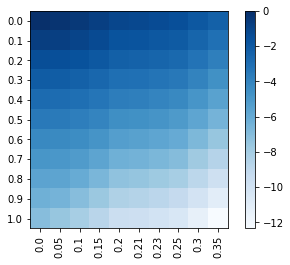

In [7]:

plt.figure()
Es = []
t_U = []
mu_U = []
for U in Us:
    for mu in mus:
        print('-'*40)
        for t in ts:
            print("U =", U)
            print("mu =", mu)
            print("t =", t)
            t_U.append(t/U)
            mu_U.append(mu/U)
            model, psi, energyss = dmrg_gs(7, t, U, mu, 4, chi_max=64, eps=1.e-10)
            Es.append(my_expectation_value(psi.Bs, model))
    Es = np.array(Es)
    t_U = np.array(t_U)
    mu_U = np.array(mu_U)
    print(t_U)
    print(mu_U)
    Es = np.reshape(Es, (len(mus), len(ts)))
    print("max chi = ", max(psi.get_chi()))
mu_U_lbl = np.unique(mu_U)
t_U_lbl = np.unique(t_U)
plt.xticks(ticks=np.arange(len(np.unique(t_U))),labels=t_U_lbl,rotation=90) #check x y
plt.yticks(ticks=np.arange(len(np.unique(mu_U))),labels=mu_U_lbl)
# save this plot inside a variable called hm
xmin = 0
xmax = 0.35
ymin = 0
ymax = 1.0
hm=plt.imshow(Es, cmap='Blues',interpolation="nearest") #, extent = (xmin,xmax,ymin,ymax)
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.show()

In [8]:
print(Es)
print(t_U)
print(mu_U)
print(len(np.unique(t_U)))
print(len(np.unique(mu_U)))
print(len(Es))

[[ 6.26885752e-33 -2.19289365e-01 -4.70360335e-01 -7.52235501e-01
  -1.08993302e+00 -1.16084261e+00 -1.30548192e+00 -1.45349405e+00
  -1.88908063e+00 -2.34916266e+00]
 [-7.00000000e-01 -7.59772911e-01 -9.69494685e-01 -1.27570442e+00
  -1.64144375e+00 -1.72022792e+00 -1.88245768e+00 -2.05020241e+00
  -2.52808206e+00 -3.04897980e+00]
 [-1.40000000e+00 -1.45977291e+00 -1.63626828e+00 -1.92033519e+00
  -2.29522214e+00 -2.37914123e+00 -2.55439242e+00 -2.73832996e+00
  -3.22808206e+00 -3.79907917e+00]
 [-2.10000000e+00 -2.15977291e+00 -2.33626828e+00 -2.62033519e+00
  -2.99522214e+00 -3.07914123e+00 -3.25439242e+00 -3.43832996e+00
  -4.00055426e+00 -4.60730977e+00]
 [-2.80000000e+00 -2.85977291e+00 -3.03626828e+00 -3.32033519e+00
  -3.69522214e+00 -3.79475528e+00 -4.00822565e+00 -4.22802719e+00
  -4.82983256e+00 -5.50730977e+00]
 [-3.50000000e+00 -3.55977291e+00 -3.73626828e+00 -4.02033519e+00
  -4.49065970e+00 -4.59475528e+00 -4.82219359e+00 -5.07579158e+00
  -5.72983256e+00 -6.47627539e+00

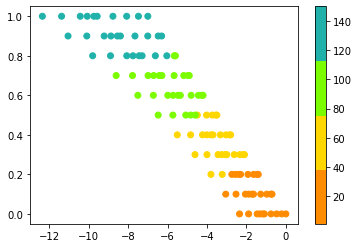

In [12]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

cm.get_cmap('viridis', 8)

import matplotlib.colors

norm=plt.Normalize(1,150)
cmap = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])
c=np.linspace(0,150,110)
plt.scatter(Es, mu_U,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [ ]:
plt.figure()
mu_U_lbl = np.unique(mu_U)
t_U_lbl = np.unique(t_U)
plt.xticks(ticks=np.arange(len(np.unique(t_U))),labels=t_U_lbl,rotation=90) #check x y
plt.yticks(ticks=np.arange(len(np.unique(mu_U))),labels=mu_U_lbl)
# save this plot inside a variable called hm
xmin = 0
xmax = 0.3
ymin = 0
ymax = 0.3
hm=plt.imshow(Es, cmap='Blues',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.show()

In [ ]:
#ignore this cell ! 


plt.figure()
for U in [1.0]:
    Es = []
    for mu in mus:
        print('-'*40)
        for t in ts:
            print("U =", U)
            print("mu =", mu)
            print("t =", t)
            model, psi, energyss = dmrg_gs(7, t, U, mu, 5, chi_max=64, eps=1.e-10)
            Es.append(model.energy(psi))
    Es = np.array(Es)
    Es = np.reshape(Es, (len(mus), len(ts)))
    print("max chi = ", max(psi.get_chi()))
plt.yticks(ticks=np.arange(len(mus)),labels=mus,rotation=90)
plt.xticks(ticks=np.arange(len(ts)),labels=ts)
# save this plot inside a variable called hm
hm=plt.imshow(Es, cmap='Blues',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.show()



plt.figure()
Es = []
for U in Us:
    for mu in [1.0]:
        print('-'*40)
        for t in ts:
            print("U =", U)
            print("mu =", mu)
            print("t =", t)
            model, psi = dmrg_gs(7, t, U, mu, 5, chi_max=64, eps=1.e-10)
            Es.append(model.energy(psi))
Es = np.array(Es)
Es = np.reshape(Es, (len(Us), len(ts)))
print("max chi = ", max(psi.get_chi()))
plt.yticks(ticks=np.arange(len(mus)),labels=mus,rotation=90)
plt.xticks(ticks=np.arange(len(ts)),labels=ts)
# save this plot inside a variable called hm
hm=plt.imshow(Es, cmap='Blues',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.show()



plt.figure()
for U in Us:
    Es = []
    for mu in mus:
        print('-'*40)
        for t in [1.0]:
            print("U =", U)
            print("mu =", mu)
            print("t =", t)
            model, psi = dmrg_gs(7, t, U, mu, 5, chi_max=64, eps=1.e-10)
            Es.append(model.energy(psi))
Es = np.array(Es)
Es = np.reshape(Es, (len(Us), len(mus)))
print("max chi = ", max(psi.get_chi()))
plt.yticks(ticks=np.arange(len(mus)),labels=mus,rotation=90)
plt.xticks(ticks=np.arange(len(ts)),labels=ts)
# save this plot inside a variable called hm
hm=plt.imshow(Es, cmap='Blues',interpolation="nearest")
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.show()


In [ ]:
#also can ignore

plt.figure()
U_ss = [0.0, 0.5, 1.0, 2.0]
Es = []
for U in U_ss:
    print("U =", U)
    model, psi = dmrg_gs(5, 1.5, U, 0.4, 5, chi_max=64, eps=1.e-10)
    Es.append(model.energy(psi))
Es = np.array(Es)
print(Es)
U_ss = np.array(U_ss)
print("max chi = ", max(psi.get_chi()))
plt.plot(U_ss, Es, marker='o')
#plt.xscale('log')
plt.xlabel('U')
plt.ylabel('energy')
plt.legend()
plt.show()

In [4]:
#Correlation function section 


# e)
def correlation_function(psi, X, Y, i):
    L = psi.L
    assert i < L
    corrs = []
    # first case: j = i
    # Note: psi.get_theta(i) = Lambda[i] B[i] with axes vL i vR
    theta = psi.get_theta1(i)  # vL i vR
    X_Y_theta = np.tensordot(np.dot(X, Y), # i [i*], [i] i*
                             theta, axes=([1], [1]))  # i [i*], vL [i] vR
    contr = np.tensordot(theta.conj(), X_Y_theta, axes=([0, 1, 2], [1, 0, 2]))  # [vL*] [i*] [vR*], [i] [vL] [vR]
    corrs.append(contr)
    # now for i < j
    theta = psi.get_theta1(i)  # vL i vR
    LP = np.tensordot(X, theta, axes=([1], [1]))  # i [i*], vL [i] vR
    LP = np.tensordot(theta.conj(), LP, axes=([0, 1], [1, 0])) # [vL*] [i*] vR*, [i] [vL] vR
    # now LP has axes vR*, vR
    for j in range(i+1, L):
        # contract with B Y B* to evaluate the correlation function for given j
        B = psi.Bs[j]  # vL j vR
        Y_B = np.tensordot(Y, B, axes=([1], [1])) # j [j*], vL [j] vR
        contr = np.tensordot(LP, Y_B, axes=([1], [1])) # vR* [vR], j [vL] vR
        contr = np.tensordot(contr, B.conj(), axes=([0, 1, 2], [0, 1, 2])) # [vR*] [j] [vR], [vL*] [j*] [vR*]
        corrs.append(contr.item())
        # get next LP for next i
        LP = np.tensordot(LP, B, axes=([1], [0])) # vR* [vR], [vL] j vR
        LP = np.tensordot(B.conj(), LP, axes=([0, 1], [0, 1])) # [vL*] [j*] vR*, [vR*] [j] vR
    return np.real_if_close(corrs)

"""
# just to test it
model, psi, energyss = dmrg_gs(7, 0.1, 1.0, 0.4, 4, chi_max=64, eps=1.e-10)
correlation_fn = correlation_function(psi, cr, ann, model.L//2)

print(correlation_fn)
"""

'\n# just to test it\nmodel, psi, energyss = dmrg_gs(7, 0.1, 1.0, 0.4, 4, chi_max=64, eps=1.e-10)\ncorrelation_fn = correlation_function(psi, cr, ann, model.L//2)\n\nprint(correlation_fn)\n'

In [ ]:
"""
num = model.init_number_op()
id = np.eye(model.d)
density = correlation_function(psi, num, id, model.L//2)

print(density)
"""

In [ ]:
plt.figure()
ncs = [0,1,2,3,4]
corrs = []
densities = []
t_U = []
mu_U = []
for U in Us:
    for mu in mus:
        print('-'*40)
        for t in ts:
            for nc in ncs:
                print("U =", U)
                print("mu =", mu)
                print("t =", t)
                print("nc =", nc)
                t_U.append(t/U)
                mu_U.append(mu/U)
                model, psi, energyss = dmrg_gs(5, t, U, mu, 4, chi_max=64, eps=1.e-10)
                cr = model.init_creation_op() 
                ann = model.init_annihilation_op()
                corr = correlation_function(psi, cr, ann, model.L//4)
                print(corr)
                corrs.append(corr)
                num = model.init_number_op()
                id = np.eye(model.d)
                density = correlation_function(psi, num, id, model.L//2)
                print(density)
                densities.append(density)
    t_U = np.array(t_U)
    mu_U = np.array(mu_U)
    ncs = np.array(ncs)
    print(t_U)
    print(mu_U)
    print(ncs)
    corrs = np.reshape(corrs, (len(np.unique(mu_U)),len(np.unique(t_U)),len(np.unique(ncs)),len(corr)))#why 4 -> no sites?
    densities = np.reshape(densities, (len(np.unique(mu_U)),len(np.unique(t_U)),len(np.unique(ncs)),len(density))) #why 3?
    print("max chi = ", max(psi.get_chi()))
plt.xticks(ticks=np.arange(len(t_U)),labels=t_U,rotation=90)
plt.yticks(ticks=np.arange(len(mu_U)),labels=mu_U)
# save this plot inside a variable called hm
hm=plt.imshow(corrs, cmap='Blues',interpolation="nearest")
hm2=plt.imshow(densities, cmap='Blues',interpolation="nearest")

# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.colorbar(hm2)
plt.show()

In [ ]:
plt.figure()
corrs = np.reshape(corrs, (len(np.unique(mu_U)),len(np.unique(t_U)),len(np.unique(ncs)),4))#why 4 -> no sites?
densities = np.reshape(densities, (len(np.unique(mu_U)),len(np.unique(t_U)),len(np.unique(ncs)),3)) #why 3?
print("max chi = ", max(psi.get_chi()))
plt.xticks(ticks=np.arange(len(t_U)),labels=t_U,rotation=90)
plt.yticks(ticks=np.arange(len(mu_U)),labels=mu_U)
# save this plot inside a variable called hm
hm=plt.imshow(corrs, cmap='Blues',interpolation="nearest")
hm2=plt.imshow(densities, cmap='Blues',interpolation="nearest")

# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.colorbar(hm2)
plt.show()

In [ ]:
corrs = np.reshape(corrs, (7*len(mus), len(ts)))
densities = np.reshape(densities, (5*len(mus), len(ts)))
print("max chi = ", max(psi.get_chi()))
plt.yticks(ticks=np.arange(len(t_U)),labels=t_U,rotation=90)
plt.xticks(ticks=np.arange(len(mu_U)),labels=mu_U)
# save this plot inside a variable called hm
hm=plt.imshow(corrs, cmap='Blues',interpolation="nearest")
hm2=plt.imshow(densities, cmap='Blues',interpolation="nearest")

# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.colorbar(hm2)
plt.show()

In [ ]:
print(corrs)

In [ ]:
plt.figure()
plt.plot(corrs[0], np.unique(mu_U), marker='o')
#plt.xscale('log')
plt.xlabel('U')
plt.ylabel('energy')
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(corrs[1], np.unique(t_U), marker='o')
#plt.xscale('log')
plt.xlabel('U')
plt.ylabel('energy')
plt.legend()
plt.show()

----------------------------------------
U = 1
mu = -0.1
t = 0.0
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  1
[0. 0. 0. 0.]
<num> = [0. 0. 0. 0. 0.]
U = 1
mu = -0.1
t = 0.1
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  4
[0.50187329 0.36548816 0.27964977 0.23036918]
<num> = [0.29675123 0.50187329 0.40275095 0.50187329 0.29675123]
U = 1
mu = -0.1
t = 0.2
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  7
[0.64229337 0.53437283 0.43183301 0.36698802]
<num> = [0.51850198 0.64229337 0.6784093  0.64229337 0.51850198]
U = 1
mu = -0.1
t = 0.30000000000000004
sweep 0
sweep 1
sweep 2
sweep 3
sweep 4
sweep 5
sweep 6
sweep 7
sweep 8
sweep 9
max final bond dimension:  10
[0.85609718 0.74697347 0.65684166 0.54159867]
<num> = [0.71321353 0.85609718 0.86445473 0.85609718 0.71167545]
U = 1
mu = -0.1
t = 0.4
sweep 0
sweep 

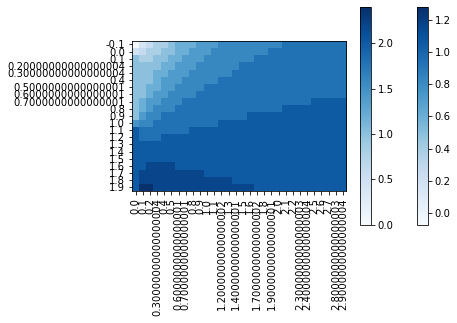

In [40]:
plt.figure()
mus = np.arange(-0.1, 2.0, 0.1)
ts = np.arange(0.0, 3.0, 0.1)
Us = [1]
ncs = [0,1,2,3,4]
corrs1 = []
densities1 = []
t_U = []
mu_U = []
for U in Us:
    for mu in mus:
        print('-'*40)
        for t in ts:
            print("U =", U)
            print("mu =", mu)
            print("t =", t)
            #print("nc =", nc)
            t_U.append(t/U)
            mu_U.append(mu/U)
            model, psi, energyss = dmrg_gs(5, t, U, mu, 3, chi_max=64, eps=1.e-10)
            cr = model.init_creation_op() 
            ann = model.init_annihilation_op()
            num = model.init_number_op()
            id = np.eye(model.d)
            corr1 = correlation_function(psi, cr, ann, model.L//4)
            print(corr1)
            corrs1.append(corr1[(3*3)//4])
            den_exp_val = psi.site_expectation_value(num)  # only for i >= L//4
            print("<num> =", den_exp_val)
            den_exp_val_avg = np.average(den_exp_val)
            #density1 = correlation_function(psi, num, id, model.L//2)
            #print(density1)
            densities1.append(den_exp_val_avg)
    t_U = np.array(t_U)
    mu_U = np.array(mu_U)
    ncs = np.array(ncs)
    print(t_U)
    print(mu_U)
    corrs1 = np.reshape(corrs1, (len(np.unique(mu_U)),len(np.unique(t_U))))#why 4 -> no sites? ,len(corr1)
    densities1 = np.reshape(densities1, (len(np.unique(mu_U)),len(np.unique(t_U)))) #why 3?
    print("max chi = ", max(psi.get_chi()))
mu_U_lbl = np.unique(mu_U)
print(corrs1.shape)
print(densities1.shape)
plt.xticks(ticks=np.arange(len(t_U)),labels=t_U,rotation=90)
plt.yticks(ticks=np.arange(len(mu_U)),labels=mu_U_lbl)
# save this plot inside a variable called hm
hm=plt.imshow(corrs1, cmap='Blues',interpolation="nearest")
hm2=plt.imshow(densities1, cmap='Blues',interpolation="nearest")

# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.colorbar(hm2)
plt.show()

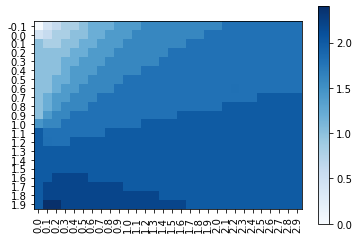

In [41]:
plt.figure()
mu_U_lbl = np.around(np.unique(mu_U), decimals = 2)
t_U_lbl = np.around(t_U, decimals=2)
plt.xticks(ticks=np.arange(len(t_U)),labels=t_U_lbl,rotation=90)
plt.yticks(ticks=np.arange(len(mu_U)),labels=mu_U_lbl)
# save this plot inside a variable called hm
hm2=plt.imshow(densities1, cmap='Blues',interpolation="nearest")

# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm2)
plt.show()

[[ 0.00000000e+00  2.79649774e-01  4.31833013e-01  6.56841659e-01
   7.29229703e-01  9.16046871e-01  1.08599433e+00  1.11056586e+00
   1.12920261e+00  1.21743482e+00  1.22477618e+00  1.23066228e+00
   1.26640338e+00  1.26835971e+00  1.26995927e+00  1.27128655e+00
   1.27240211e+00  1.27335034e+00  1.27416438e+00  1.27486946e+00
   1.27548501e+00  1.27614575e+00  1.27640648e+00  1.27663468e+00
   1.27683547e+00  1.27701303e+00  1.27717077e+00  1.27731149e+00
   1.27743752e+00  1.27755082e+00]
 [-7.08632297e-02  3.09190444e-01  5.52082405e-01  6.56841659e-01
   8.48194895e-01  9.16046871e-01  1.08599433e+00  1.11056586e+00
   1.20806713e+00  1.21743482e+00  1.22477618e+00  1.26396947e+00
   1.26640338e+00  1.26835971e+00  1.26995927e+00  1.27128655e+00
   1.27240211e+00  1.27335034e+00  1.27416438e+00  1.27549943e+00
   1.27584607e+00  1.27614575e+00  1.27640648e+00  1.27663468e+00
   1.27683547e+00  1.27701303e+00  1.27717077e+00  1.27731149e+00
   1.27743752e+00  1.27755082e+00]
 [ 0.0

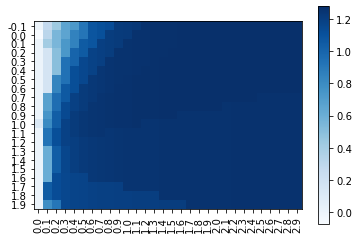

In [42]:
plt.figure()
mu_U_lbl = np.around(np.unique(mu_U), decimals = 2)
t_U_lbl = np.around(t_U, decimals=2)
plt.xticks(ticks=np.arange(len(t_U)),labels=t_U_lbl,rotation=90)
plt.yticks(ticks=np.arange(len(mu_U)),labels=mu_U_lbl)
# save this plot inside a variable called hm
hm=plt.imshow(corrs1, cmap='Blues',interpolation="nearest")
print(corrs1)
print("___")
print(densities1)
# pass this heatmap object into plt.colorbar method.
plt.colorbar(hm)
plt.show()

ValueError: x and y must be the same size

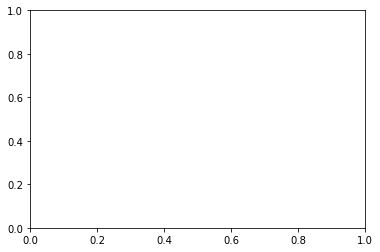

In [43]:
norm=plt.Normalize(1,150)
cmap = ListedColormap(["darkorange", "gold", "lawngreen", "lightseagreen"])
c=np.linspace(0,150,110)
plt.scatter(np.unique(densities1), t_U,c=c, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [44]:
print(np.unique(densities1).shape)

(93,)


In [46]:
print(t_U.shape)

(110,)
